In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()


In [2]:
from util import load_external_labels

#%time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [3]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

gold_labels_dev = []
for i,L in enumerate(L_gold_dev):
    gold_labels_dev.append(L[0,0])
    
gold_labels_test = []
for i,L in enumerate(L_gold_test):
    gold_labels_test.append(L[0,0])
    
print(len(gold_labels_dev),len(gold_labels_test))

(2796, 2697)


In [9]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


KeyboardInterrupt: 

In [26]:
from scipy.optimize import minimize
import cPickle as pickle


def print_details(estimator):
        print("on dev set:")
        print("###########  softmax_th",estimator.softmax_th," lf_th",estimator.lf_th, "########################")
        LAMDA,SCORE = estimator.get_LAMDA(dev_cands)
        P_cap = estimator.get_P_cap(LAMDA,SCORE,estimator.THETA)
        marginals= estimator.get_marginals(P_cap)
        plt.hist(marginals, bins=20)
        plt.show()
        plt.bar(range(0,len(LAMDA)),marginals) #2796 = len(LAMDA) for Spouse
        plt.show()
        predicted_labels=estimator.predict_labels(marginals)
        print(len(marginals),len(predicted_labels),len(gold_labels_dev))
        #score(predicted_labels,self.gold_labels_dev)
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
        return predicted_labels


import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}


family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}

family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend', 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    


import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])



In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin

import numpy as np

np.random.seed(78)
class Custom_Estimator(BaseEstimator, ClassifierMixin): # y is dummy
    def __init__(self,LFs,lf_th=0.5,softmax_th=0.5):
        self.lf_th = lf_th
        self.softmax_th = softmax_th
        self.LFs = LFs
        self.THETA = np.random.rand(len(LFs),1)
        self.dev_cands = dev_cands
        self.gold_labels_dev = gold_labels_dev

        
    def PHI(self,K,LAMDAi,SCOREi):
        return [K*l*s for (l,s) in zip(LAMDAi,SCOREi)]

    def softmax(self,THETA,LAMDAi,SCOREi):
        x = []
        for k in [1,-1]:
            product = np.dot(self.PHI(k,LAMDAi,SCOREi),THETA)
            x.append(product)
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    
    def predict(self,X,y=None):
        print("predicting:")
        print("###########  softmax_th",self.softmax_th," lf_th",self.lf_th, "########################")
        LAMDA,SCORE = self.get_LAMDA(X)
        P_cap = self.get_P_cap(LAMDA,SCORE,self.THETA)
        marginals = self.get_marginals(P_cap)
        plt.hist(marginals, bins=20)
        plt.show()
        plt.bar(range(0,len(LAMDA)),marginals) #2796 = len(LAMDA) for Spouse
        plt.show()
        predicted_labels=self.predict_labels(marginals)
        return predicted_labels


    def classify(self, inputs):
        return self.predict(inputs)
    
    def fit(self,X,y=None): # X is train_cands
        self.train(train_cands)
        return self

    
    def predict_labels(self,marginals):
        predicted_labels=[]
        for i in marginals:
            if(i<0.5):
                predicted_labels.append(-1)
            else:
                predicted_labels.append(1)
        return predicted_labels
    
    def get_marginals(self,P_cap):
        marginals = []
        for P_capi in P_cap:
            marginals.append(P_capi[0])
        return marginals
    
    def get_P_cap(self,LAMDA,SCORE,THETA):
        P_cap = []
        for i in range(len(LAMDA)):
            P_capi = self.softmax(THETA,LAMDA[i],SCORE[i])
            P_cap.append(P_capi)
        return P_cap

    def PHIj(self,j,K,LAMDAi,SCOREi):
        return LAMDAi[j]*K*SCOREi[j]

    def RIGHT(self,j,LAMDAi,SCOREi,THETA):
        phi = []
        for k in [1,-1]:
            phi.append(self.PHIj(j,k,LAMDAi,SCOREi))
        x = self.softmax(THETA,LAMDAi,SCOREi)
        return np.dot(phi,x)

    def get_LAMDA(self,cands):
        LAMDA = []
        SCORE = []
        for ci in cands:
            L=[]
            S=[]
            P_ik = []
            for LF in self.LFs:
                #print LF.__name__
                LF = getattr(Custom_Estimator,LF)
                l,s = LF(self,ci)
                L.append(l)
                S.append((s+1)/2)  #to scale scores in [0,1] 
            LAMDA.append(L)
            SCORE.append(S) 
        return LAMDA,SCORE

    def get_Confidence(self,LAMDA):
        confidence = []
        for L in LAMDA:
            Total_L = float(len(L))
            No_zeros = L.count(0)
            No_Non_Zeros = Total_L - No_zeros
            confidence.append(No_Non_Zeros/Total_L)
        return confidence    

    def get_Initial_P_cap(self,LAMDA):
        P_cap = []
        for L in LAMDA:
            P_ik = []
            denominator=float(L.count(1)+L.count(-1))
            if(denominator==0):
                denominator=1
            P_ik.append(L.count(1)/denominator)
            P_ik.append(L.count(-1)/denominator)
            P_cap.append(P_ik)
        return P_cap
    
    def function(self,THETA,LAMDA,SCORE,P_cap):
        s = 0.0
        i = 0
        for i in range(len(LAMDA)):
            s = s + np.dot(np.log(self.softmax(THETA,LAMDA[i],SCORE[i])),P_cap[i])
            i = i+1
        return -s
    
    def function_der(self,THETA,LAMDA,SCORE,P_cap):
        der = []
        for j in range(len(THETA)):
            i = 0
            s = 0.0
            for index in range(len(LAMDA)):
                p = 0
                for K in [1,-1]:
                    s = s + (self.PHIj(j,K,LAMDA[index],SCORE[index])-self.RIGHT(j,LAMDA[index],SCORE[index],THETA))*P_cap[i][p]
                    p = p+1
                i = i+1
            der.append(-s)
        return np.array(der)
    
    def get_params(self, deep = False):
        return {'lf_th':self.lf_th,'softmax_th':self.softmax_th,'LFs':self.LFs}

    
    def score(self,X,y=None):
        LAMDA,SCORE = self.get_LAMDA(X)
        P_cap = self.get_Initial_P_cap(LAMDA)
        res = self.function(self.THETA,LAMDA,SCORE,P_cap)
        return -res - self.softmax_th - self.lf_th       
  
    
    def train(self,train_cands,No_Iter=2,Use_Confidence=False,theta_file_name="THETA"):
        LAMDA,SCORE = self.get_LAMDA(train_cands)
        P_cap = self.get_Initial_P_cap(LAMDA)
        #Confidence = get_Confidence(LAMDA)
        for iteration in range(No_Iter):
            if(Use_Confidence==True):
                res = minimize(self.function_conf,self.THETA,args=(LAMDA,P_cap,Confidence), method='BFGS',jac=function_conf_der,options={'disp': True, 'maxiter':20}) #nelder-mead
            else:
                res = minimize(self.function,self.THETA,args=(LAMDA,SCORE,P_cap), method='BFGS',jac=self.function_der,options={'disp': True, 'maxiter':20}) #nelder-mead            
            self.THETA = res.x # new THETA
            print(self.THETA)
            P_cap = self.get_P_cap(LAMDA,SCORE,self.THETA) #new p_cap 
            print_details(self)
            #score(predicted_labels,gold_labels)
        NP_P_cap = np.array(P_cap)
        np.savetxt('Train_P_cap.txt', NP_P_cap, fmt='%f')
        pickle.dump(NP_P_cap,open("Train_P_cap.p","wb"))
        NP_THETA = np.array(self.THETA)
        np.savetxt(theta_file_name+'.txt', NP_THETA, fmt='%f') 
        pickle.dump( NP_THETA, open( theta_file_name+'.p', "wb" )) # save the file as "outfile_name.npy" 
    

    def LF_husband_wife(self,c):
        sc = 0
        word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
        for sw in spouses:
            sc=max(sc,get_similarity(word_vectors,sw))
        if sc < self.lf_th:
            return (0,0)
        return (1,sc)

    def LF_husband_wife_left_window(self,c):
        sc_1 = 0
        word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
        for sw in spouses:
            sc_1=max(sc_1,get_similarity(word_vectors,sw))

        sc_2 = 0
        word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
        for sw in spouses:
            sc_2=max(sc_2,get_similarity(word_vectors,sw))
        if max(sc_1,sc_2)< self.lf_th:
            return (0,0)
        return(1,max(sc_1,sc_2))

    def LF_same_last_name(self,c):
        p1_last_name = last_name(c.person1.get_span())
        p2_last_name = last_name(c.person2.get_span())
        if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
            if c.person1.get_span() != c.person2.get_span():
                return (1,1)
        return (0,0)

    def LF_no_spouse_in_sentence(self,c):
        return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

    def LF_and_married(self,c):

        word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
        sc = get_similarity(word_vectors,'married')
        if sc< self.lf_th:
            return (0,0)
        if 'and' in get_between_tokens(c):
            return (1,sc)
        else:
            return (0,0)

    def LF_familial_relationship(self,c):

        sc = 0
        word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
        for fw in family:
            sc=max(sc,get_similarity(word_vectors,fw))

        if sc < self.lf_th:
            return (0,0)
        return (-1,sc) 

    def LF_family_left_window(self,c):

        sc_1 = 0
        word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
        for fw in family:
            sc_1=max(sc_1,get_similarity(word_vectors,fw))

        sc_2 = 0
        word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
        for fw in family:
            sc_2=max(sc_2,get_similarity(word_vectors,fw))

        if max(sc_1,sc_2)< self.lf_th:
            return (0,0)
        return (-1,max(sc_1,sc_2))

    def LF_other_relationship(self,c):
        sc = 0
        word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
        for ow in other:
            sc=max(sc,get_similarity(word_vectors,ow))

        if sc < self.lf_th:
            return (0,0)
        return (-1,sc) 

    def LF_other_relationship_left_window(self,c):
        sc = 0
        word_vectors = get_word_vectors(preprocess(get_left_tokens(c)))
        for ow in other:
            sc=max(sc,get_similarity(word_vectors,ow))
        if sc < self.lf_th:
            return (0,0)
        return (-1,sc) 

    
    def LF_distant_supervision(self,c):
        p1, p2 = c.person1.get_span(), c.person2.get_span()
        return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

    def LF_distant_supervision_last_names(self,c):
        p1, p2 = c.person1.get_span(), c.person2.get_span()
        p1n, p2n = last_name(p1), last_name(p2)
        return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)


    def LF_Three_Lists_Left_Window(self,c):
        c1,s1 = self.LF_husband_wife_left_window(c)
        c2,s2 = self.LF_family_left_window(c)
        c3,s3 = self.LF_other_relationship_left_window(c)
        sc = np.array([s1,s2,s3])
        c = [c1,c2,c3]
        sharp_param = 1.5
        prob_sc = np.exp(sc * sharp_param - np.max(sc))
        prob_sc = prob_sc / np.sum(prob_sc)
        #print 'Left:',s1,s2,s3,prob_sc

        if s1==s2 or s3==s1 or np.max(sc)< self.softmax_th:
            return (0,0)
        return c[np.argmax(prob_sc)],1

    def LF_Three_Lists_Between_Words(self,c):
        c1,s1 = self.LF_husband_wife(c)
        c2,s2 = self.LF_familial_relationship(c)
        c3,s3 = self.LF_other_relationship(c)
        sc = np.array([s1,s2,s3])
        c = [c1,c2,c3]
        sharp_param = 1.5

        prob_sc = np.exp(sc * sharp_param - np.max(sc))
        prob_sc = prob_sc / np.sum(prob_sc)
        #print 'BW:',s1,s2,s3,prob_sc
        if s1==s2 or s3==s1 or np.max(sc)< self.softmax_th:
            return (0,0)
        return c[np.argmax(prob_sc)],1




         Current function value: 2352.151586
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
[ 1.20656819  1.17424564  2.0758725   2.83307905  1.49719201  1.53154863
  2.1083652 ]
on dev set:
('###########  softmax_th', 0.40862889957616788, ' lf_th', 0.31699017683739783, '########################')


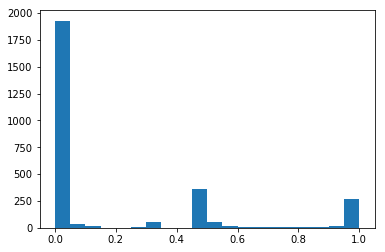

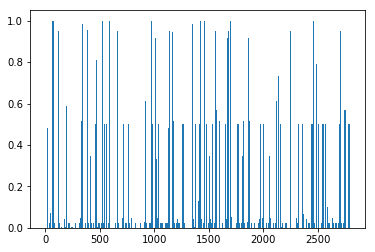

(2796, 2796, 2796)
(0.17598908594815826, 0.65816326530612246, 0.27771797631862216, None)
Optimization terminated successfully.
         Current function value: 4169.583430
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 1.20656819  1.17424564  2.0758725   2.83307905  1.49719201  1.53154863
  2.1083652 ]
on dev set:
('###########  softmax_th', 0.40862889957616788, ' lf_th', 0.31699017683739783, '########################')


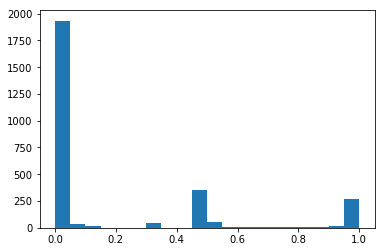

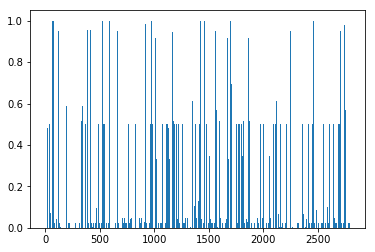

(2796, 2796, 2796)
(0.17857142857142858, 0.66326530612244894, 0.2813852813852814, None)
Optimization terminated successfully.
         Current function value: 2343.269734
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
[ 1.14764553  1.13482781  2.05443887  2.8909961   1.49748388  1.53766736
  2.11860622]
on dev set:
('###########  softmax_th', 0.40862889957616788, ' lf_th', 0.31699017683739783, '########################')


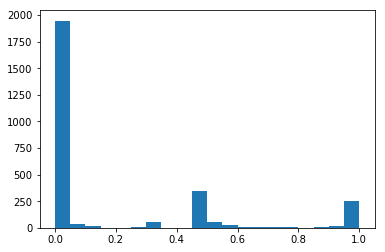

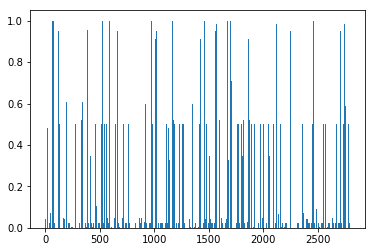

(2796, 2796, 2796)
(0.18945868945868946, 0.6785714285714286, 0.29621380846325163, None)
Optimization terminated successfully.
         Current function value: 4173.871432
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 1.14764553  1.13482781  2.05443887  2.8909961   1.49748388  1.53766736
  2.11860622]
on dev set:
('###########  softmax_th', 0.40862889957616788, ' lf_th', 0.31699017683739783, '########################')


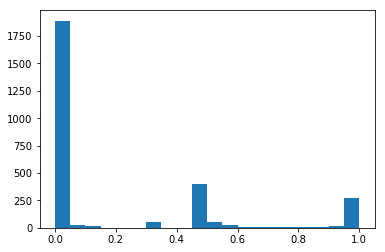

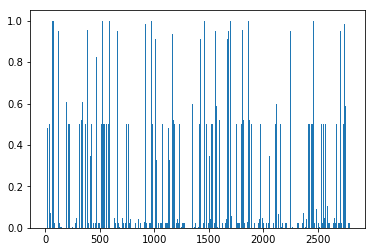

(2796, 2796, 2796)
(0.16752577319587628, 0.66326530612244894, 0.26748971193415638, None)
         Current function value: 2330.751761
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
[ 1.06956123  0.99552236  2.14032283  2.85055833  1.49816978  1.54570408
  2.11012001]
on dev set:
('###########  softmax_th', 0.40862889957616788, ' lf_th', 0.31699017683739783, '########################')


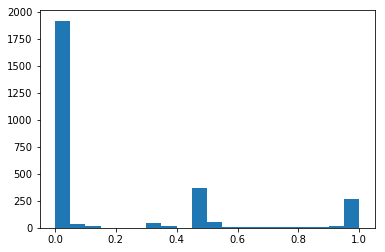

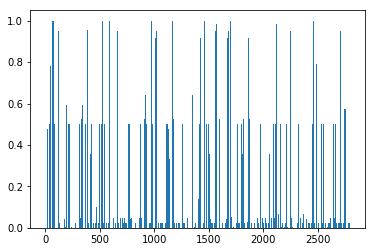

(2796, 2796, 2796)
(0.17255434782608695, 0.64795918367346939, 0.27253218884120173, None)
Optimization terminated successfully.
         Current function value: 4182.841086
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 1.06956123  0.99552236  2.14032283  2.85055833  1.49816978  1.54570408
  2.11012001]
on dev set:
('###########  softmax_th', 0.40862889957616788, ' lf_th', 0.31699017683739783, '########################')


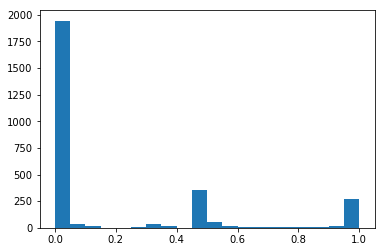

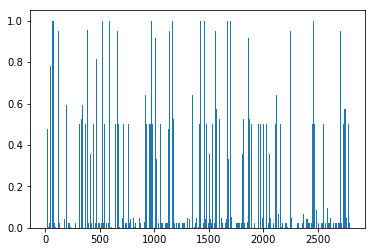

(2796, 2796, 2796)
(0.18093922651933703, 0.66836734693877553, 0.2847826086956522, None)
         Current function value: 2406.823474
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
[ 0.82004359  1.13587109  2.0084334   2.8006647   1.48112536  1.52503664
  2.08537697]
on dev set:
('###########  softmax_th', 0.40511224046074296, ' lf_th', 0.31699017683739783, '########################')


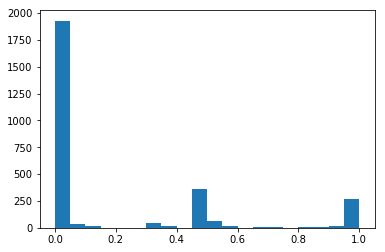

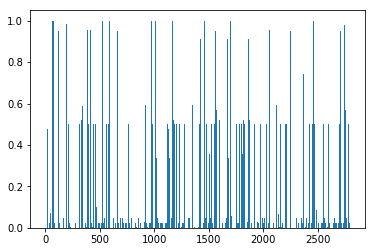

(2796, 2796, 2796)
(0.17719780219780221, 0.65816326530612246, 0.27922077922077926, None)
Optimization terminated successfully.
         Current function value: 4233.977134
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.82004359  1.13587109  2.0084334   2.8006647   1.48112536  1.52503664
  2.08537697]
on dev set:
('###########  softmax_th', 0.40511224046074296, ' lf_th', 0.31699017683739783, '########################')


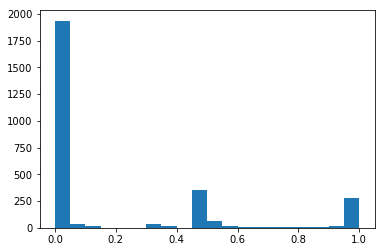

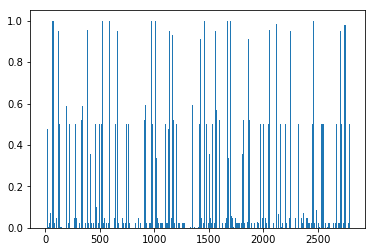

(2796, 2796, 2796)
(0.17832647462277093, 0.66326530612244894, 0.2810810810810811, None)
         Current function value: 2388.452602
         Iterations: 20
         Function evaluations: 55
         Gradient evaluations: 53
[ 0.78684948  1.15853407  1.95261549  2.83469079  1.49032607  1.53714266
  2.08167533]
on dev set:
('###########  softmax_th', 0.40511224046074296, ' lf_th', 0.31699017683739783, '########################')


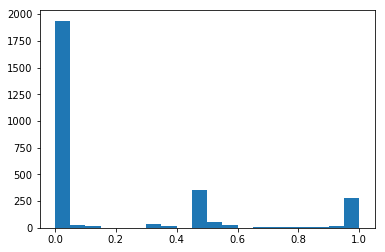

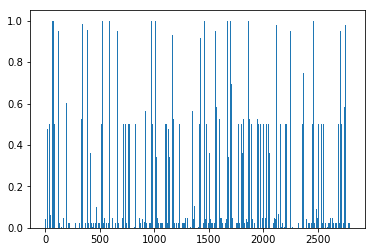

(2796, 2796, 2796)
(0.18181818181818182, 0.67346938775510201, 0.28633405639913234, None)
Optimization terminated successfully.
         Current function value: 4216.281895
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.78684948  1.15853407  1.95261549  2.83469079  1.49032607  1.53714266
  2.08167533]
on dev set:
('###########  softmax_th', 0.40511224046074296, ' lf_th', 0.31699017683739783, '########################')


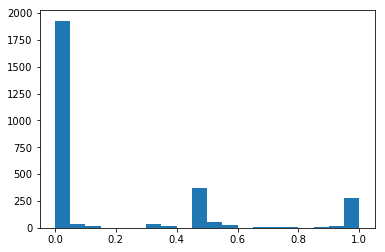

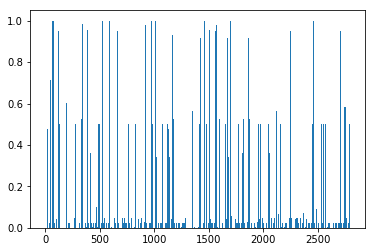

(2796, 2796, 2796)
(0.18070652173913043, 0.6785714285714286, 0.28540772532188846, None)
         Current function value: 2413.309795
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 27
[ 0.74690112  1.21950605  2.03393595  2.80012436  1.47792397  1.5256364
  2.06841688]
on dev set:
('###########  softmax_th', 0.40511224046074296, ' lf_th', 0.31699017683739783, '########################')


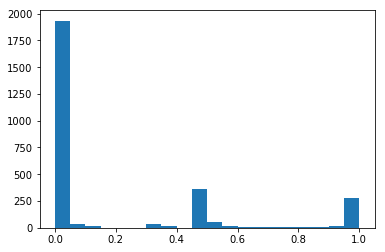

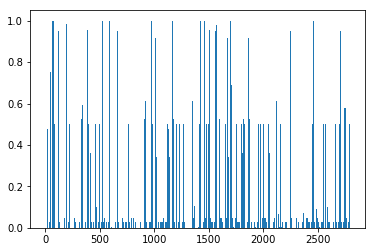

(2796, 2796, 2796)
(0.17574931880108993, 0.65816326530612246, 0.27741935483870972, None)
Optimization terminated successfully.
         Current function value: 4264.712078
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.74690112  1.21950605  2.03393595  2.80012436  1.47792397  1.5256364
  2.06841688]
on dev set:
('###########  softmax_th', 0.40511224046074296, ' lf_th', 0.31699017683739783, '########################')


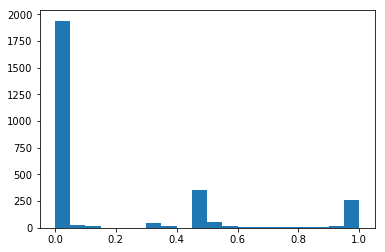

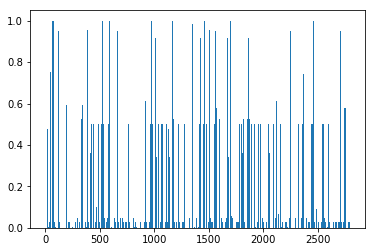

(2796, 2796, 2796)
(0.17679558011049723, 0.65306122448979587, 0.27826086956521734, None)
         Current function value: 2576.840993
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
[ 0.67234212  1.09948621  1.97363006  2.78170863  1.42367804  1.48930036
  1.99823482]
on dev set:
('###########  softmax_th', 0.39955817059510612, ' lf_th', 0.31699017683739783, '########################')


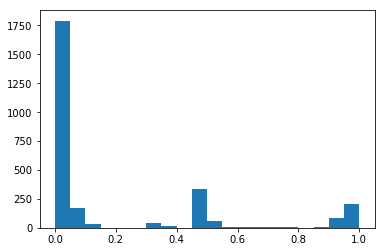

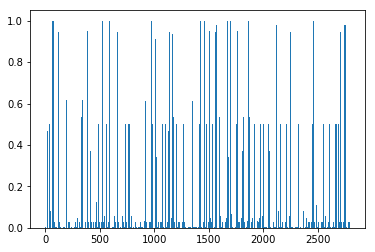

(2796, 2796, 2796)
(0.18591549295774648, 0.67346938775510201, 0.29139072847682118, None)
Optimization terminated successfully.
         Current function value: 4239.008540
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.67234212  1.09948621  1.97363006  2.78170863  1.42367804  1.48930036
  1.99823482]
on dev set:
('###########  softmax_th', 0.39955817059510612, ' lf_th', 0.31699017683739783, '########################')


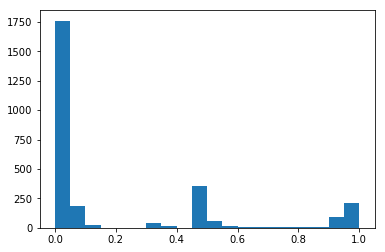

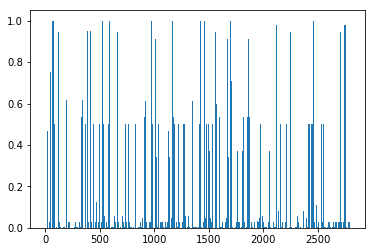

(2796, 2796, 2796)
(0.18095238095238095, 0.6785714285714286, 0.2857142857142857, None)


In [ ]:
from scipy.stats import uniform
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV

LFs = ['LF_distant_supervision', 'LF_distant_supervision_last_names','LF_same_last_name',
       'LF_and_married', 'LF_Three_Lists_Between_Words','LF_Three_Lists_Left_Window', 'LF_no_spouse_in_sentence'
      ]

from sklearn.metrics import precision_recall_fscore_support
rv = uniform()

clf = Custom_Estimator(LFs = LFs)

def scoring_func(estimator,X,y=None):
    return estimator.score(X)

#rs = RandomizedSearchCV(estimator=clf,
#                  param_distributions={'softmax_th': rv,'lf_th':rv},
#                 scoring=scoring_func, n_iter=2, n_jobs=1)

rs = GridSearchCV(estimator=clf,
                  param_grid={'softmax_th': sf_r,'lf_th':lf_r},
                  scoring=scoring_func, n_jobs=1)

rs.fit(train_cands,None)




<class 'scipy.stats._distn_infrastructure.rv_frozen'>
(array([ 0.4086289 ,  0.40511224,  0.39955817,  0.33481833,  0.48640155,
        0.35372812,  0.28717862,  0.33605613,  0.40249064,  0.44609756]), array([ 0.31699018,  0.67021426,  0.79214362,  0.45867842,  0.34799037,
        0.43957801,  0.95536917,  0.58556336,  0.58638658,  0.8952152 ]))


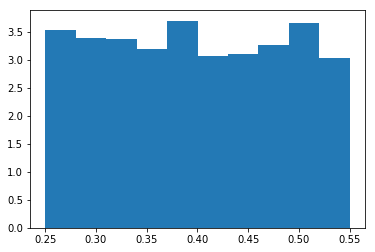

In [46]:
rv = uniform()
print(type(rv))
sf_r = uniform.rvs(loc=0.25,scale=0.3,size=10)
lf_r = uniform.rvs(loc=0.3,scale=0.9,size=10)
print(sf_r,lf_r)
fig, ax = plt.subplots(1, 1)
ax.hist(r, normed=True, histtype='stepfilled', alpha=5)
ax.legend(loc='best', frameon=False)
plt.show()

         Current function value: 1242.906483
         Iterations: 16
         Function evaluations: 155
         Gradient evaluations: 142
[ 2.03650774  0.67314792  2.3369195   2.47217276  2.00444859  1.50217892
  2.90203389]
train iteration: 0


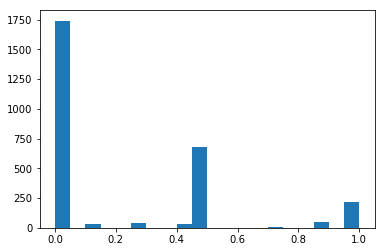

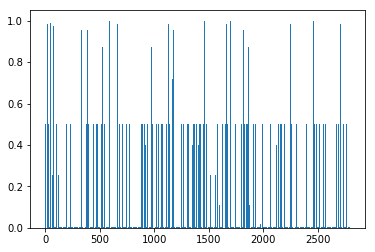

(2796, 2796, 2796)
(0.13333333333333333, 0.6428571428571429, 0.22085889570552147, None)
Optimization terminated successfully.
         Current function value: 4862.520853
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 2.03650774  0.67314792  2.3369195   2.47217276  2.00444859  1.50217892
  2.90203389]
train iteration: 1


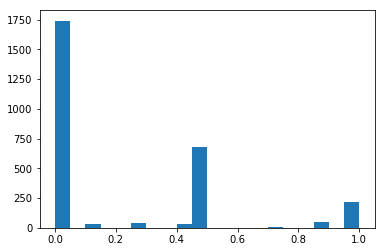

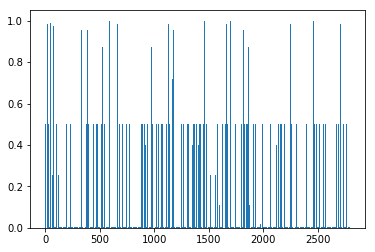

(2796, 2796, 2796)
(0.13333333333333333, 0.6428571428571429, 0.22085889570552147, None)
test:


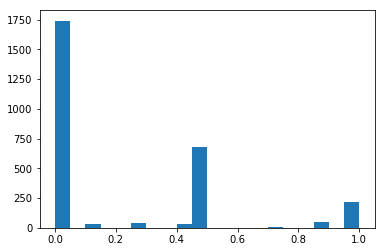

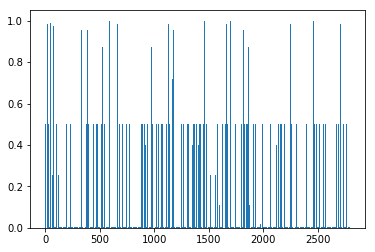

(2796, 2796, 2796)
(0.13333333333333333, 0.6428571428571429, 0.22085889570552147, None)


In [33]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
    
dev_LAMDA,dev_SCORE = get_LAMDA(dev_cands)

#write_to_file(wordvec_unavailable)

# All LF_Threshold =0.8 and softmax_Threshold=0.7 ,three fourth removed-2
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

Optimization terminated successfully.
         Current function value: 287.377300
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
[ 3.45450582  0.66558336  3.69786424  3.72659838  0.87571888  1.52627452
  4.33458061]
train iteration: 0


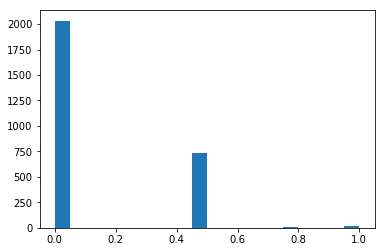

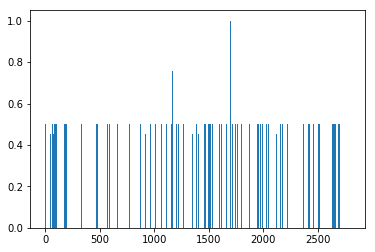

(2796, 2796, 2796)
(0.084269662921348312, 0.30612244897959184, 0.13215859030837004, None)
Optimization terminated successfully.
         Current function value: 4071.960895
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 3.45450582  0.66558336  3.69786424  3.72659838  0.87571888  1.52627452
  4.33458061]
train iteration: 1


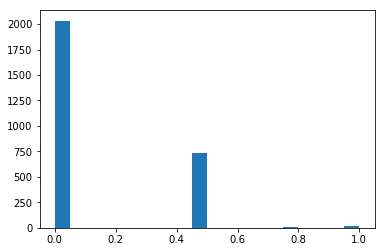

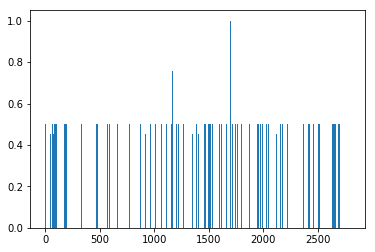

(2796, 2796, 2796)
(0.084269662921348312, 0.30612244897959184, 0.13215859030837004, None)
test:


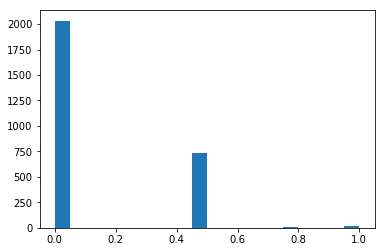

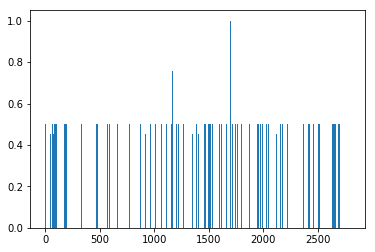

(2796, 2796, 2796)
(0.084269662921348312, 0.30612244897959184, 0.13215859030837004, None)


In [29]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
    
dev_LAMDA,dev_SCORE = get_LAMDA(dev_cands)

#write_to_file(wordvec_unavailable)

# All LF_Threshold =0.8 and softmax_Threshold=0.7 ,three fourth removed
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

Optimization terminated successfully.
         Current function value: 1536.396147
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
[ 1.756606    0.72228253  2.1110369   2.27587191  1.80001088  1.52627452
  2.71643542]
train iteration: 0


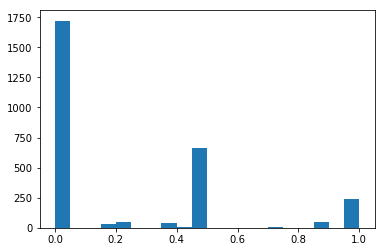

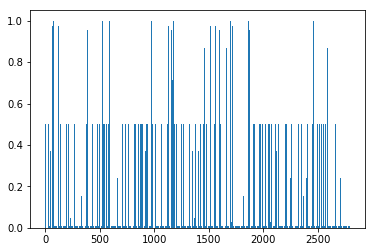

(2796, 2796, 2796)
(0.13807531380753138, 0.67346938775510201, 0.22916666666666666, None)
Optimization terminated successfully.
         Current function value: 5083.230264
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 1.756606    0.72228253  2.1110369   2.27587191  1.80001088  1.52627452
  2.71643542]
train iteration: 1


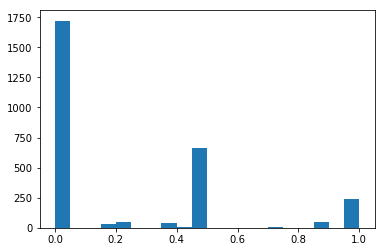

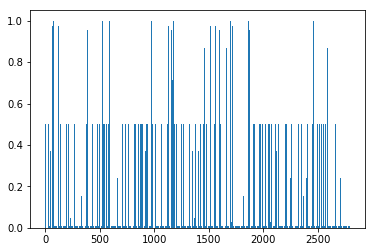

(2796, 2796, 2796)
(0.13807531380753138, 0.67346938775510201, 0.22916666666666666, None)
test:


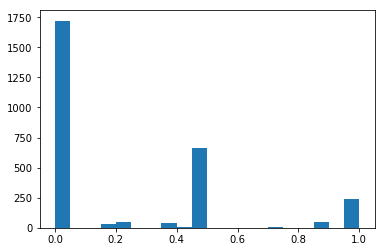

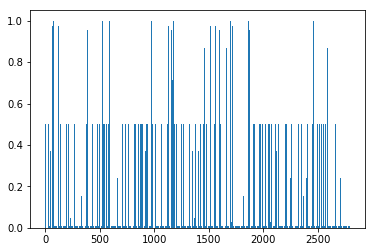

(2796, 2796, 2796)
(0.13807531380753138, 0.67346938775510201, 0.22916666666666666, None)


In [27]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
    
dev_LAMDA,dev_SCORE = get_LAMDA(dev_cands)

#write_to_file(wordvec_unavailable)

# All LF_Threshold =0.8 and softmax_Threshold=0.7 ,half removed
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

         Current function value: 1208.307357
         Iterations: 20
         Function evaluations: 29
         Gradient evaluations: 29
[ 1.86740842  0.84429949  2.26350895  2.4033164   1.77989364  1.68111137
  2.86360725]
train iteration: 0


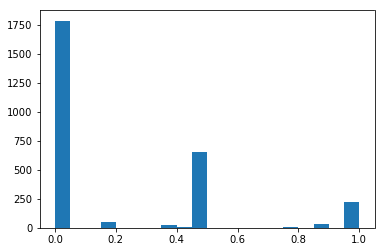

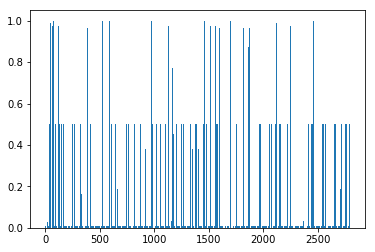

(2796, 2796, 2796)
(0.13129102844638948, 0.61224489795918369, 0.21621621621621617, None)
Optimization terminated successfully.
         Current function value: 4717.018384
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 1.86740842  0.84429949  2.26350895  2.4033164   1.77989364  1.68111137
  2.86360725]
train iteration: 1


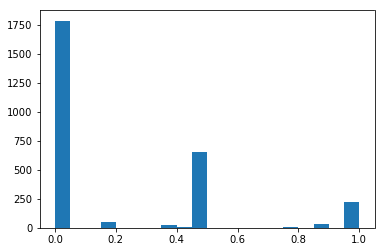

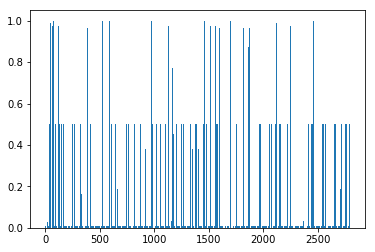

(2796, 2796, 2796)
(0.13129102844638948, 0.61224489795918369, 0.21621621621621617, None)
test:


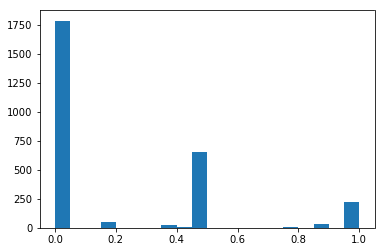

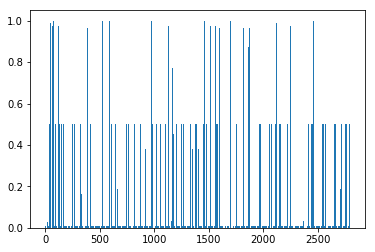

(2796, 2796, 2796)
(0.13129102844638948, 0.61224489795918369, 0.21621621621621617, None)


In [25]:
# All LF_Threshold =0.8 and softmax_Threshold=0.7 ,one fourth removed
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

         Current function value: 330.069609
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 0


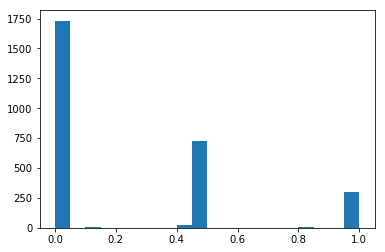

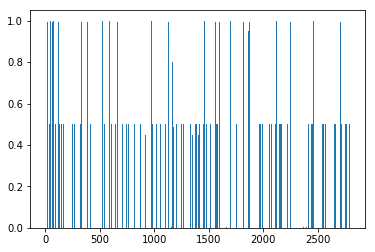

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
Optimization terminated successfully.
         Current function value: 4182.213294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 1


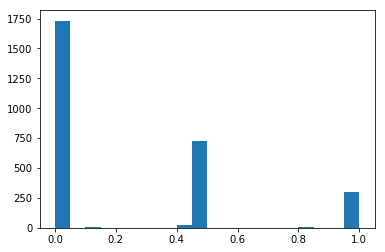

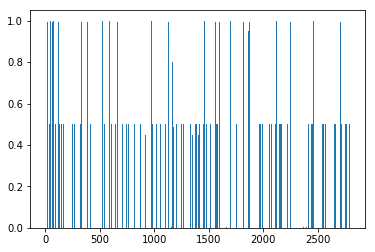

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
test:


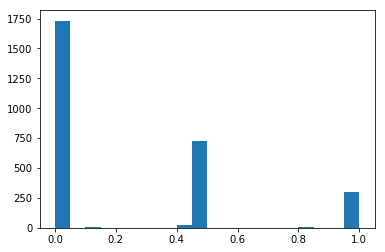

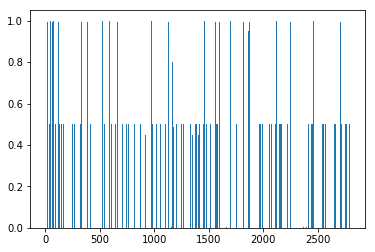

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)


In [11]:
# All LF_Threshold =0.3 and softmax_Threshold=0.5
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

         Current function value: 330.069609
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 0


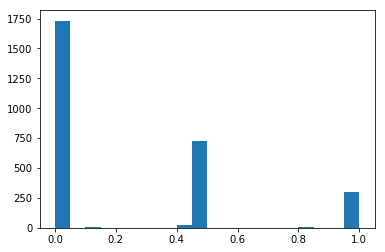

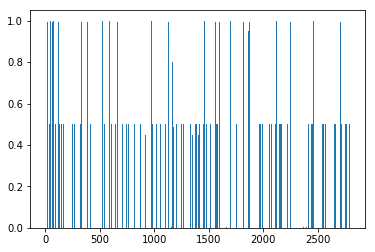

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
Optimization terminated successfully.
         Current function value: 4182.213294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 1


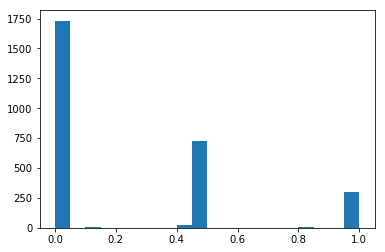

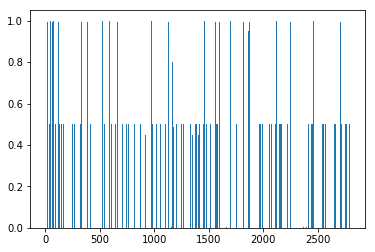

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
test:


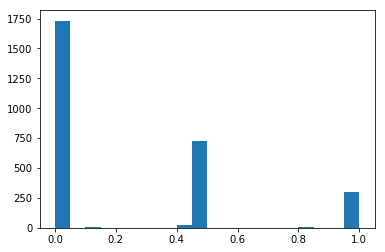

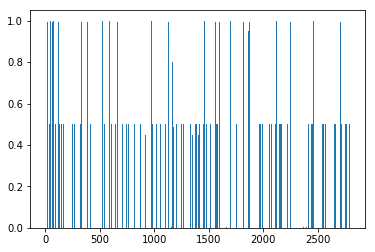

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)


In [11]:
# All LF_Threshold =0.7 and softmax_Threshold=0.7
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

         Current function value: 330.069609
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 0


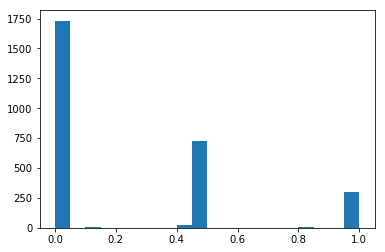

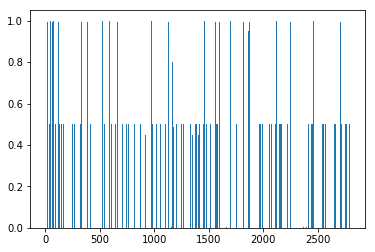

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
Optimization terminated successfully.
         Current function value: 4182.213294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 1


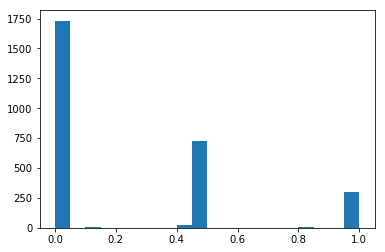

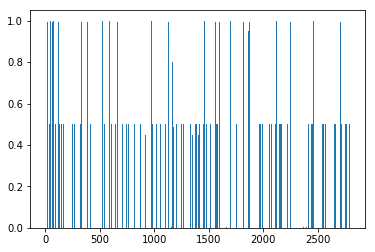

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
test:


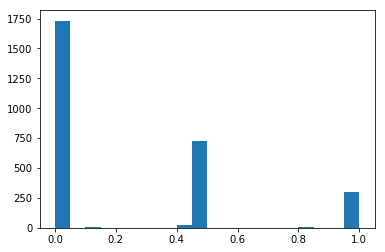

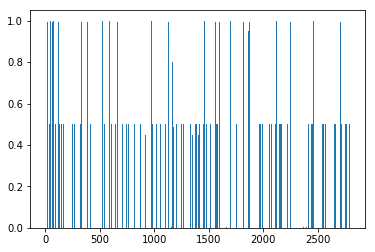

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)


In [11]:
# All LF_Threshold =0.8 and softmax_Threshold=0.5
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

In [ ]:
def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    #plt.bar(range(0,2796),marginals)
    #plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

#import cPickle as pickle
#THETA = pickle.load( open( "THETA.p", "rb" ) )
#test(THETA)
#LAMDA,SCORE = get_LAMDA(dev_cands)
#Confidence = get_Confidence(LAMDA)

#P_cap = get_P_cap(LAMDA,SCORE,THETA)
#marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()

print_details("dev set",THETA,dev_LAMDA,dev_SCORE)
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels,gold_labels_dev)))):
    if i>20:
        break
    print i,j
#print(len(marginals),len(predicted_labels),len(gold_labels_dev))
#no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
#print(len(sorted_predicted_labels[0:no_of_labels]))
no_of_labels=2796
score(predicted_labels[0:no_of_labels],gold_labels_dev[0:no_of_labels])
